## Load the dataset

In [50]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [170]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=False)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder' 'Tony Blair']
(904, 128, 128)


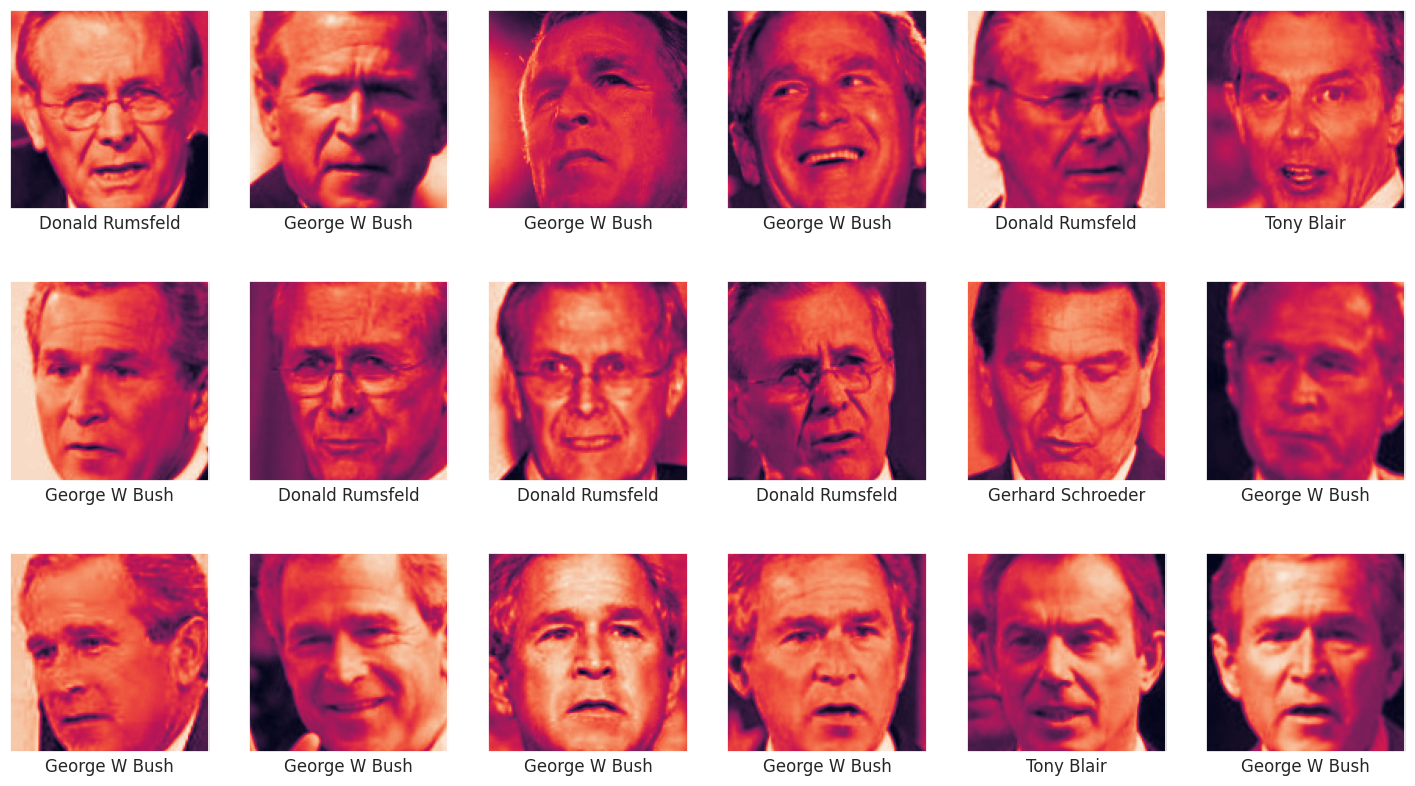

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i]) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

<Axes: >

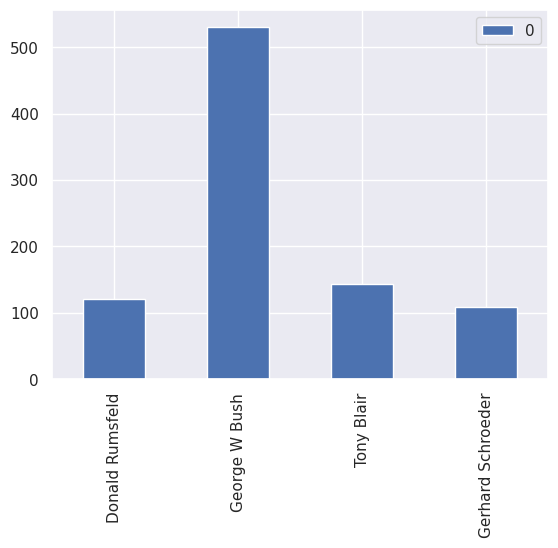

In [172]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

In [175]:
mask = np.zeros(faces.target.shape, dtype=np.bool_)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], 1))
x_faces.shape

(400, 128, 128, 1)

0
1
3
2


<Axes: >

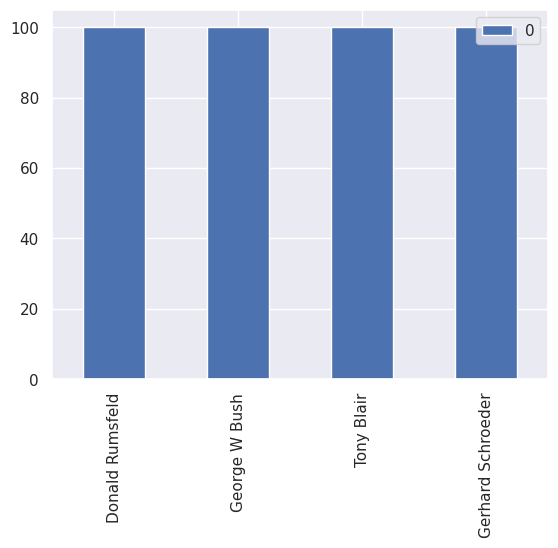

In [176]:
from collections import Counter
counts = Counter(y_faces)
names = {}

for key in counts.keys():
    print(key)
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

In [96]:
# !python -m pip install tensorflow

In [177]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = x_faces # Normalize pixel values
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, test_size=0.15, stratify=face_labels, random_state=42)

0.0

## CNN

In [181]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(face_images.shape[1:])))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 30, 30, 64)      

In [182]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=25)

Epoch 1/20
14/14 [==============================] - 6s 289ms/step - loss: 1.4996 - accuracy: 0.2853 - val_loss: 1.3859 - val_accuracy: 0.2500
Epoch 2/20
14/14 [==============================] - 4s 266ms/step - loss: 1.3896 - accuracy: 0.2500 - val_loss: 1.3854 - val_accuracy: 0.2500
Epoch 3/20
14/14 [==============================] - 4s 267ms/step - loss: 1.3829 - accuracy: 0.3176 - val_loss: 1.3781 - val_accuracy: 0.3500
Epoch 4/20
14/14 [==============================] - 4s 268ms/step - loss: 1.3665 - accuracy: 0.4088 - val_loss: 1.3454 - val_accuracy: 0.4667
Epoch 5/20
14/14 [==============================] - 4s 268ms/step - loss: 1.2473 - accuracy: 0.4824 - val_loss: 1.1486 - val_accuracy: 0.5833
Epoch 6/20
14/14 [==============================] - 4s 268ms/step - loss: 0.8937 - accuracy: 0.6647 - val_loss: 0.8811 - val_accuracy: 0.6667
Epoch 7/20
14/14 [==============================] - 4s 273ms/step - loss: 0.5454 - accuracy: 0.8147 - val_loss: 0.8951 - val_accuracy: 0.6333
Epoch 

[]

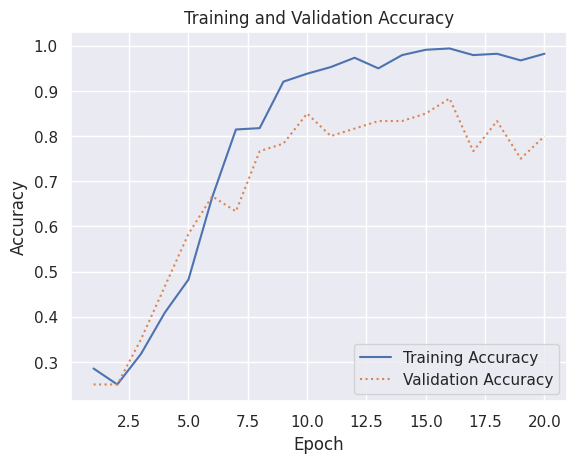

In [183]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

2/2 [==============================] - 0s 59ms/step


Text(109.44999999999996, 0.5, 'Actual label')

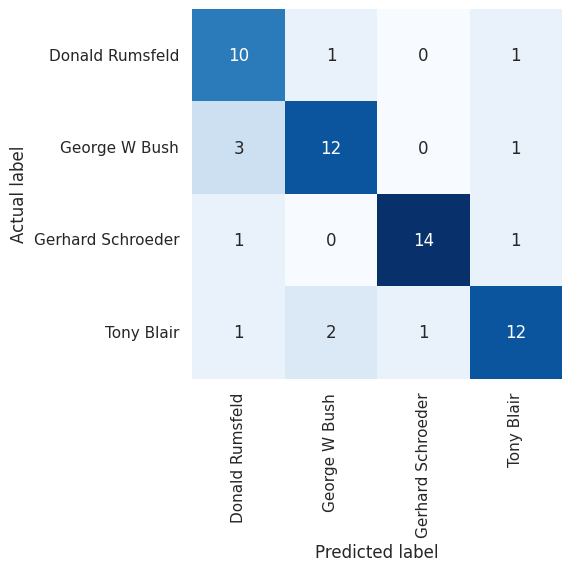

In [184]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## Pretrain VGG16

In [224]:
faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

In [225]:
mask = np.zeros(faces.target.shape, dtype=np.bool_)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(400, 128, 128, 3)

In [226]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = x_faces # Normalize pixel values
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, test_size=0.15, stratify=face_labels, random_state=42)

In [227]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Input, Lambda ,Dense ,Flatten , Dropout , GlobalAveragePooling2D

In [228]:
#vgg 16 model
classifier_vgg16 = VGG16(input_shape= (128, 128, 3),include_top=False,weights='imagenet')
classifier_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [229]:
#not train top layers
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [230]:
#adding extra layers for our class/images
main_model = classifier_vgg16.output
main_model = GlobalAveragePooling2D()(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dense(512,activation='relu')(main_model)
main_model = Dropout(0.5)(main_model)
main_model = Dense(4,activation='softmax')(main_model)

In [231]:
#compiling
model = Model(inputs = classifier_vgg16.input , outputs = main_model)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [232]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=25)

Epoch 1/20
14/14 [==============================] - 17s 1s/step - loss: 1.4875 - accuracy: 0.3059 - val_loss: 1.2505 - val_accuracy: 0.3167
Epoch 2/20
14/14 [==============================] - 17s 1s/step - loss: 1.1625 - accuracy: 0.5294 - val_loss: 0.9482 - val_accuracy: 0.6333
Epoch 3/20
14/14 [==============================] - 18s 1s/step - loss: 0.9165 - accuracy: 0.6559 - val_loss: 0.6678 - val_accuracy: 0.7500
Epoch 4/20
14/14 [==============================] - 18s 1s/step - loss: 0.6273 - accuracy: 0.7941 - val_loss: 0.4573 - val_accuracy: 0.8333
Epoch 5/20
14/14 [==============================] - 18s 1s/step - loss: 0.3973 - accuracy: 0.8471 - val_loss: 0.5371 - val_accuracy: 0.8333
Epoch 6/20
14/14 [==============================] - 18s 1s/step - loss: 0.3856 - accuracy: 0.8647 - val_loss: 0.2670 - val_accuracy: 0.8833
Epoch 7/20
14/14 [==============================] - 18s 1s/step - loss: 0.2410 - accuracy: 0.9235 - val_loss: 0.3033 - val_accuracy: 0.9000
Epoch 8/20
14/14 [==

[]

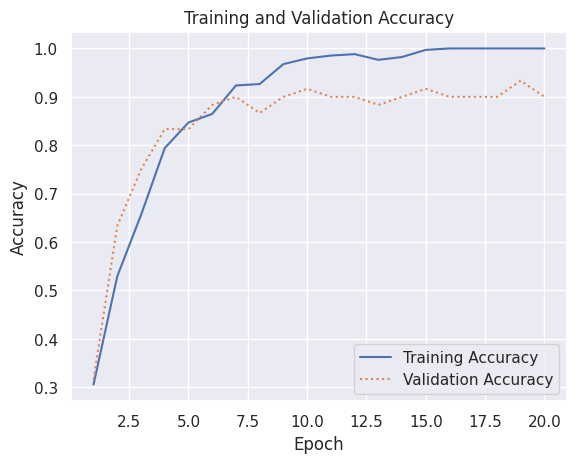

In [233]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

2/2 [==============================] - 3s 1s/step


Text(109.44999999999996, 0.5, 'Actual label')

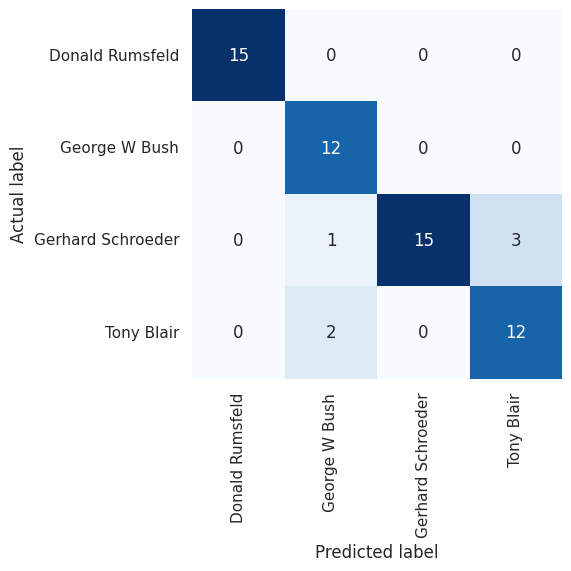

In [234]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## ResNet50 and ImageNet weights

In [248]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder' 'Tony Blair']
(904, 128, 128, 3)


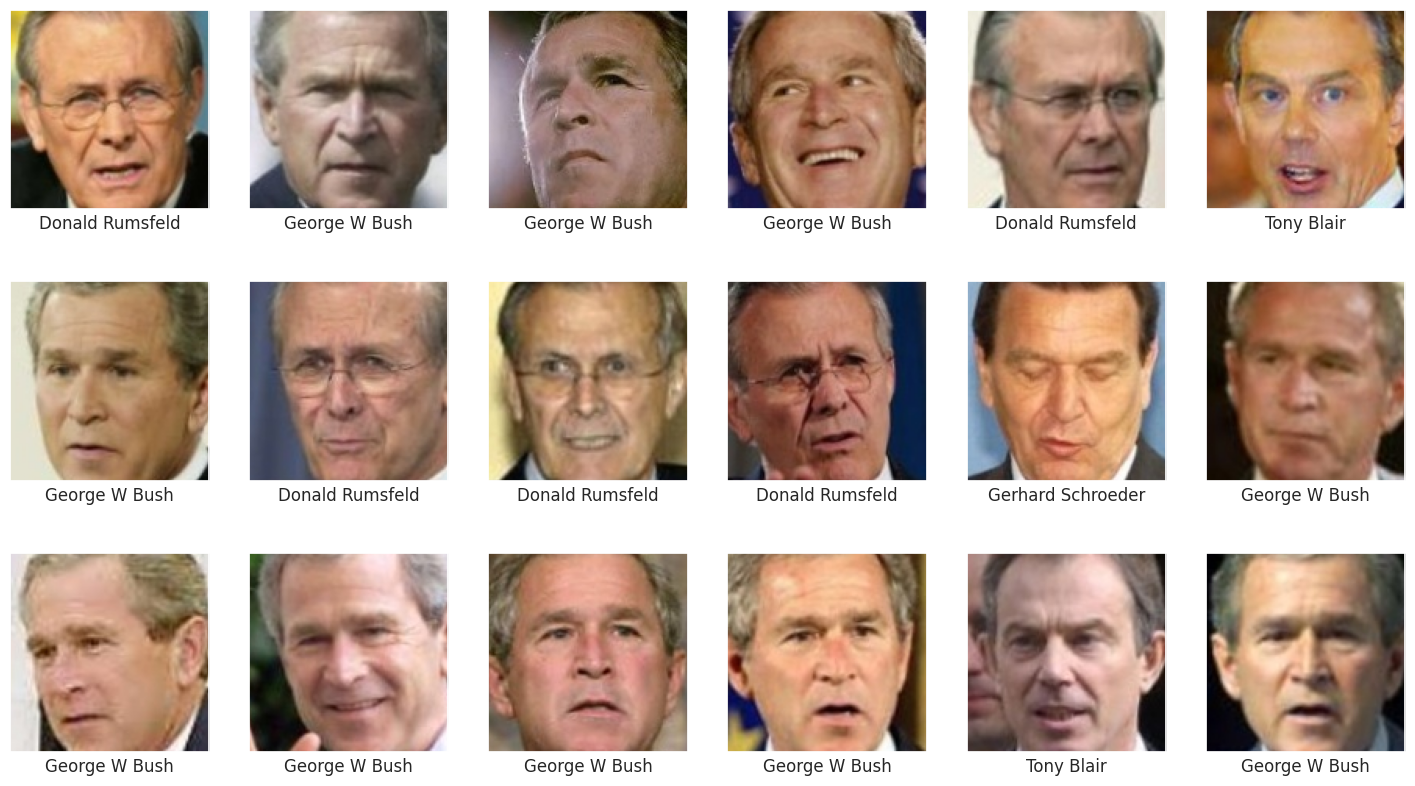

In [249]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i]) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [250]:
mask = np.zeros(faces.target.shape, dtype=np.bool_)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(400, 128, 128, 3)

In [251]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

face_images = preprocess_input(np.array(x_faces))
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)


In [252]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

In [253]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [255]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=25, epochs=20)

Epoch 1/20
13/13 [==============================] - 49s 3s/step - loss: 19.5898 - accuracy: 0.2500 - val_loss: 6.3933 - val_accuracy: 0.2500
Epoch 2/20
13/13 [==============================] - 39s 3s/step - loss: 3.8277 - accuracy: 0.2344 - val_loss: 2.1785 - val_accuracy: 0.2500
Epoch 3/20
13/13 [==============================] - 41s 3s/step - loss: 2.4938 - accuracy: 0.2969 - val_loss: 2.4819 - val_accuracy: 0.2500
Epoch 4/20
13/13 [==============================] - 39s 3s/step - loss: 1.5236 - accuracy: 0.3812 - val_loss: 1.1922 - val_accuracy: 0.5750
Epoch 5/20
13/13 [==============================] - 39s 3s/step - loss: 1.5046 - accuracy: 0.3625 - val_loss: 1.6275 - val_accuracy: 0.3750
Epoch 6/20
13/13 [==============================] - 39s 3s/step - loss: 1.6863 - accuracy: 0.3063 - val_loss: 1.8197 - val_accuracy: 0.3250
Epoch 7/20
13/13 [==============================] - 39s 3s/step - loss: 1.3117 - accuracy: 0.4437 - val_loss: 1.3506 - val_accuracy: 0.6375
Epoch 8/20
13/13 [=

[]

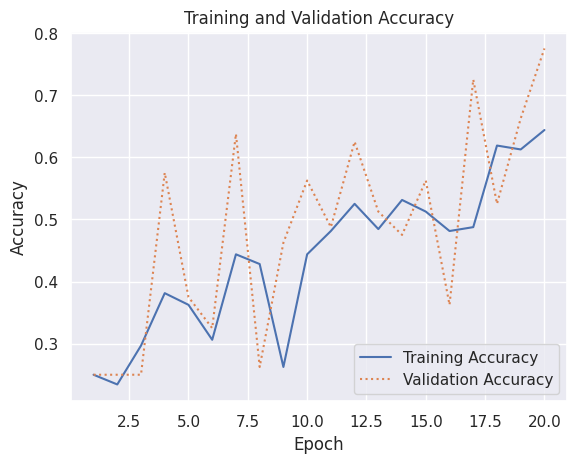

In [256]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()